# Data Science task

The task involves processing and extracting useful insights from the PTB-XL ECG data set.

## 1. Summary


The objective of this document is to acquire a general vision about the dataset and remark interesting aspects that will be found along the study. Throughout this notebook we will:

- Download, prepare and partition the dataset
- Explore and visualize the ECG data, the relations between labels and the rest of variables provided
- Provide a mechanism to identify QRS complexes by Q, R and S peaks, as well as detect potential arrhythmias
- Build a deep learning model to predict the appropriate superclasses for a given ECG
- Define a method to extract an explanation for the prediction provided by the model for any given instance


## 2. Preliminaries

This section covers the essential tasks that we need to perform in order to work with the dataset: download the data and necessary Python libraries, read the data from the downloaded files and organize it in an appropriate format for later use.

### 2.1. Notebook settings

You can modify the following settings that will alter the way the notebook works. Available settings are as follows:

- `USE_HIGHER_SAMPLING_RATE`: if enabled, uses ECG data sampled at 500Hz. Otherwise, 100Hz data is loaded. 
- `USE_GPU`: whether to use available GPU resources for deep learning model training. GPU RAM requirements may be high due to the large number of features in the dataset, so it's best to disable it if any "out of memory" errors occur.
- `USE_CABRERA`: whether to use the Cabrera format for 12-lead ECG plots. This changes the order of the leads shown on the left side (aVL, I, -aVR, II, aVF, III) for an easier interpretation according to the heart coordinate system.
- `CLASSIFICATION_THRESHOLD`: the number (between 0 and 1) from which a label is considered as predicted by the model. The default value is 0.5.

In [1]:
USE_HIGHER_SAMPLING_RATE = False
USE_GPU = False
USE_CABRERA = True
CLASSIFICATION_THRESHOLD = 0.5

### 2.2 Dependencies and data preparation

In order to keep this notebook self-contained, the next cells perform the necessary steps in order to install any needed packages, as well as download and extract the dataset. 

In [2]:
!pip install -qqr requirements.txt
!pip install -qq --no-deps git+https://github.com/emanuel-metzenthin/Lime-For-Time.git

If the data is already downloaded, you can skip the next cell and set `DATADIR` to the appropriate location. Otherwise, you can run these cells (it will take a while):

In [ ]:
!curl -o data.zip "https://physionet.org/static/published-projects/ptb-xl/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.2.zip"
!unzip -qn data.zip

In [3]:
DATADIR = "ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.2"

### 2.3. About the dataset

We are going to work on the PTB-XL ECG dataset, which contains **21801 data samples** from 18869 patients. Each data sample is composed of a standard 12-lead ECG of 10 second length (available in 100Hz and 500Hz sample rates), some metadata about the patient as well as ECG statements provided by up to two cardiologists.

The main points of interest of this dataset are its size, the statements associated to each ECG and the fact that part of these are supervised by professionals. In fact, most of the samples that are annotated by cardiologists are left in the validation and test sets so that the evaluation metrics are as precise as possible. The following code will read the data from every available ECG in an array named `X`, as well as the metadata and statements in a data frame named `Y`.

In [4]:
import pandas as pd
import numpy as np
import wfdb
import ast
import os

if not USE_GPU:
    os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [5]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(os.path.join(path, f)) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(os.path.join(path, f)) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

# switch this value to 500 to work with "hr" data files instead of "lr"
sampling_rate=500 if USE_HIGHER_SAMPLING_RATE else 100

# load and convert annotation data
Y = pd.read_csv(os.path.join(DATADIR, 'ptbxl_database.csv'), index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

# Load raw signal data
X = load_raw_data(Y, sampling_rate, DATADIR)

# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(os.path.join(DATADIR, 'scp_statements.csv'), index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

The statements are provided in the `scp_codes` variable, in the form of a dictionary: each type of diagnostic is either associated to a nonzero probability or an "absent" one, marked as zero. It is important to notice that **even if a diagnostic is assigned an unknown/zero likelihood, it still means that the diagnostic is present** for that ECG sample.

In [6]:
Y.scp_codes

ecg_id
1                 {'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}
2                             {'NORM': 80.0, 'SBRAD': 0.0}
3                               {'NORM': 100.0, 'SR': 0.0}
4                               {'NORM': 100.0, 'SR': 0.0}
5                               {'NORM': 100.0, 'SR': 0.0}
                               ...                        
21833    {'NDT': 100.0, 'PVC': 100.0, 'VCLVH': 0.0, 'ST...
21834             {'NORM': 100.0, 'ABQRS': 0.0, 'SR': 0.0}
21835                           {'ISCAS': 50.0, 'SR': 0.0}
21836                           {'NORM': 100.0, 'SR': 0.0}
21837                           {'NORM': 100.0, 'SR': 0.0}
Name: scp_codes, Length: 21801, dtype: object

Since there are more than 70 different possible diagnostics, but the authors of the dataset helpfully provide a classification into 5 superclasses, we are going to simplify the characterization of the dataset by taking into account mainly each superclass, instead of working directly with the low level diagnostics and likelihoods. For this purpose, we build a `target` data frame with a column for each superclass and a row for each data sample, where a `True` value in a given column will mean presence of that superclass in the corresponding ECG.

Notice that these superclasses are not exhaustive nor exclusive. This means that **some of the samples will be assigned more than one superclass**, and some of them will not be assigned any.

In [7]:
SUPERCLASSES = ["NORM", "HYP", "MI", "STTC", "CD"]

def aggregate_diagnostic(y_dic):
    row = pd.Series([False for _ in SUPERCLASSES], index=SUPERCLASSES)
    for key in y_dic.keys():
        if key in agg_df.index and agg_df.loc[key].diagnostic_class in SUPERCLASSES:
            row[agg_df.loc[key].diagnostic_class] = True
    return row

target = Y.scp_codes.apply(aggregate_diagnostic)
target[100:110]

,NORM,HYP,MI,STTC,CD
ecg_id,,,,,
101,True,False,False,False,False
102,False,False,False,True,True
103,False,False,True,False,True
104,True,False,False,False,False
105,True,False,False,False,False
106,False,True,True,False,False
107,True,False,False,False,False
108,True,False,False,False,False
109,True,False,False,False,False


Next, we'll split data into training and testing sets. Stratified cross-validation sets are already provided within the data. We'll mainly work on the training set for exploratory analysis, use the validation set to assess model performance while training and the test set will only be used to conduct a final evaluation of the models.

In [8]:
test_fold = 10
val_fold = 9
is_test = Y.strat_fold == test_fold
is_val = Y.strat_fold == val_fold

# Train
X_train = X[np.where(-is_test * -is_val)]
y_train = target[-is_test * -is_val]
# Val
X_val = X[np.where(is_val)]
y_val = target[is_val]
# Test
X_test = X[np.where(is_test)]
y_test = target[is_test]

## 3. Exploratory data analysis
### 3.1. Labels and metadata exploration

This section is dedicated to analyzing the metadata and labels associated to each data sample in the database, in the hope that this will provide an intuition on what kind of useful information could be extracted from the dataset.

By listing all variables available in the `Y` data frame, we can see that the metadata provided includes:

- demographic information (although, for anonymization purposes, ages above 89 years are presented as above 300); 
- information about where, when and by whom the ECG was taken;
- whether the diagnostic was not supervised, validated by one human or by two;
- presence of possible noise or circumstances that would affect the signal (pacemakers, problems with the electrodes, extra systoles);
- the locations of the R peaks in the ECG and the heart axis;
- dataset-related information (file names, fold number);
- diagnostic (`scp_codes`) and other variables related to it

With regards to demographics, we can appreciate that the population sample seems relatively old (the median is 62 years old) but with high variance, so there is representation of all ages, and is pretty well balanced with regards to sex. 

In [9]:
Y.describe(include=[np.number])

,patient_id,age,sex,height,weight,nurse,site,validated_by,strat_fold
count,21801.000000,21801.000000,21801.000000,6975.000000,9422.000000,20326.000000,21783.000000,12421.000000,21801.000000
mean,11250.554287,62.769781,0.479106,166.703226,70.996391,2.291745,1.545012,0.746075,5.503142
std,6235.025560,32.307421,0.499575,10.866804,15.878365,3.254033,4.172799,1.178003,2.874868
min,302.000000,2.000000,0.000000,6.000000,5.000000,0.000000,0.000000,0.000000,1.000000
25%,5975.000000,50.000000,0.000000,160.000000,60.000000,0.000000,0.000000,0.000000,3.000000
50%,11419.000000,62.000000,0.000000,166.000000,70.000000,1.000000,1.000000,1.000000,6.000000
75%,16608.000000,72.000000,1.000000,174.000000,80.000000,3.000000,2.000000,1.000000,8.000000
max,21797.000000,300.000000,1.000000,209.000000,250.000000,11.000000,50.000000,11.000000,10.000000


In [10]:
Y.describe(include=[object])

,device,recording_date,report,scp_codes,heart_axis,infarction_stadium1,infarction_stadium2,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,filename_lr,filename_hr,r_peaks
count,21801,21801,21801,21801,13331,5613,103,1599,3260,613,30,1949,291,21801,21801,21801
unique,11,21795,9888,5300,8,6,3,318,124,103,14,128,4,21801,21801,21799
top,CS100 3,1992-02-06 11:47:42,sinus rhythm. normal ecg.,"{'NORM': 100.0, 'SR': 0.0}",MID,unknown,Stadium III,", V6",", I-AVR,",alles,V6,1ES,"ja, pacemaker",records100/00000/00001_lr,records500/00000/00001_hr,[ 91 182 270 357 449 539 630 721 810 899 989]
freq,6140,2,1734,6144,7687,3431,65,221,953,140,8,405,285,1,1,2


Many of the provided variables present missing values. We could differentiate, in this context, two kinds of missing data: **those that indicate no presence of the corresponding variable** (e.g. no static noise, no extra beats, no pacemaker) and **those that leave the variable with only partial information** (e.g. missing height, weight or heart axis). However, the fact that there exist many unannotated instances with the latter kind poses the question of whether all noises and problems are actually indicated as such, or there may be some missing as well. Additionally, the `infarction_stadium1` variable has more values than instances labeled with "myocardic infarction" but includes more than 3000 instances marked as `"unknown"`. As a result, there is little incentive to rely on these variables unless a thorough data cleaning process were performed.

In [11]:
missing = Y.isna().sum()
display(missing[missing!=0])

height                 14826
weight                 12379
nurse                   1475
site                      18
heart_axis              8470
infarction_stadium1    16188
infarction_stadium2    21698
validated_by            9380
baseline_drift         20202
static_noise           18541
burst_noise            21188
electrodes_problems    21771
extra_beats            19852
pacemaker              21510
dtype: int64

If we inspect the `target` data frame, we can find that there are some instances where no label is present. This is due to some annotations not having a corresponding superclass in the statements database (`agg_df`). For example, `AFLT` meaning "atrial flutter" or `PACE` indicating the presence of a pacemaker. As seen below, **only 405 of all samples are not assigned a superclass**. They can remain in the dataset since the empty labelset is a valid one and a classifier should be able to predict it, but we could consider removing them as well, since they arise from different circumstances, and perform classification on just the superclasses.

In [12]:
Y[(target.sum(axis=1) == 0)].scp_codes

ecg_id
17       {'AFLT': 100.0, 'ABQRS': 0.0, 'AFIB': 0.0}
18                                  {'AFLT': 100.0}
20                    {'AFLT': 100.0, 'ABQRS': 0.0}
23                                  {'AFLT': 100.0}
34                                  {'AFLT': 100.0}
                            ...                    
21578                               {'PACE': 100.0}
21594                               {'PACE': 100.0}
21602                               {'PACE': 100.0}
21689                               {'PACE': 100.0}
21817                               {'PACE': 100.0}
Name: scp_codes, Length: 405, dtype: object

Analyzing label frequency and imbalance in a dataset can reveal which labels could be difficult to learn by a classifier. In this case, there is a predominance of the normal (`NORM`) label, and three of the labels indicating different pathologies are represented approximately half as much, but **the `HYP` superclass is notably underrepresented, at just 12% of cases**. If this hinders classification performance, it would be possible to resample instances in an attempt to balance the representations of each label. However, the `HYP` label could appear closely coupled with other labels, which would make balancing the dataset much more difficult.

In [13]:
pd.DataFrame(
    data=np.array([target.sum(), target.mean() * 100, np.max(target.sum()) / target.sum()]),
    index=["Count", "Frequency", "Imbalance ratio"],
    columns=target.columns
)

,NORM,HYP,MI,STTC,CD
Count,9517.000000,2649.000000,5473.000000,5237.000000,4901.000000
Frequency,43.653961,12.150819,25.104353,24.021834,22.480620
Imbalance ratio,1.000000,3.592676,1.738900,1.817262,1.941849


A preliminar way of inspecting which labels are more coupled would be computing all possible labelsets appearing in the dataset. Since we are working with just five labels, this is feasible and fairly interpretable. In the following results, each digit corresponds with a superclass, 1 indicating presence and 0 indicating absence. For example, `10000` means the labelset with just the label `NORM`, and is the most common with more than 9000 instances. An interesting case is label `HYP`, which **is more frequent in the labelset `01010` (i.e. coupled with `STTC`) than by itself**.

This could mean that patients that present `HYP` are prone to also presenting `STTC`. For the purposes of learning the `HYP` label, this also means that any preprocessing applied to the data would have to take into account the frequent coupling of this label with others (of all 2649 cases where it appears, just 535 instances are assigned only the `HYP` label).

In [14]:
labelsets = target.apply(lambda r: "".join(r.apply(lambda x: "1" if x else "0")), axis=1)
labelsets.value_counts()

10000    9072
00100    2532
00010    2401
00001    1708
00101    1300
01010     781
00110     600
01000     535
00011     471
10001     407
00000     405
01110     361
01001     300
00111     223
01011     211
01100     183
01111     156
01101     117
10010      28
10011       5
11001       2
11000       2
11101       1
dtype: int64

A more visual way to detect couplings among labels is by drawing their coocurrence plot. This plot shows one circular track per label, and **links from one track to another where the width indicates the proportion of instances that are assigned those two labels** (and potentially others). Different colors simply help distinguish the links. It is heavily inspired by [the one implemented in package mldr](https://github.com/fcharte/mldr/blob/master/R/graphics.R#L91) for multilabel learning in R (for which I am a co-author and maintainer). Please notice that the plot only shows coupling levels between pairs of labels, as well as the proportion of instances where the label appears alone.

In [15]:
from matplotlib import pyplot as plt
from pycirclize import Circos

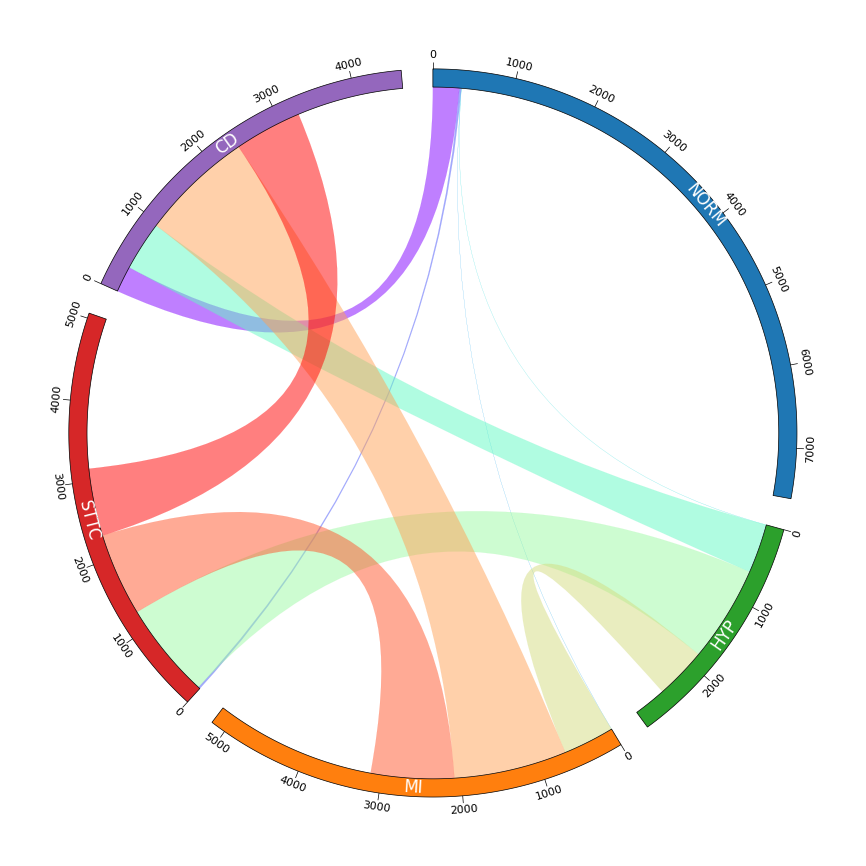

In [16]:
def coocurrence_plot(labels):
    plt.close()

    # Start by counting instances where each label appears alone
    total = {s: (labels.iloc[np.where(labels[s] == 1)].sum(axis=1) == 1).sum() for s in SUPERCLASSES}
    coocurrences = {
        SUPERCLASSES[s1]: {
            SUPERCLASSES[s2]: 0 
            for s2 in range(s1 + 1, len(SUPERCLASSES))
        }
        for s1 in range(len(SUPERCLASSES) - 1)
    }

    # Count coocurrences for each pair of labels
    for s1 in coocurrences.keys():
        for s2 in coocurrences[s1].keys():
            coocurrences[s1][s2] = (labels[s1] * labels[s2]).sum()
            total[s1] += coocurrences[s1][s2]
            total[s2] += coocurrences[s1][s2]

    # Draw tracks in the circos plot
    track_colors = dict(zip(total.keys(), ['tab:blue', 'tab:green', 'tab:orange', 'tab:red', 'tab:purple']))
    circos = Circos(total, space=5)
    for sector in circos.sectors:
        track = sector.add_track((95, 100))
        track.axis(fc=track_colors[sector.name])
        track.text(sector.name, color="white", size=12)
        track.xticks_by_interval(1000)

    # Draw the links joining labels by its number of coocurrences
    cm = plt.get_cmap("rainbow")
    step = {s: 0 for s in SUPERCLASSES}
    c = 0
    total_colors = np.sum([len(v) for k, v in coocurrences.items()]) - 1
    for s1 in coocurrences.keys():
        for s2 in reversed(coocurrences[s1].keys()):
            circos.link((s1, step[s1], step[s1] + coocurrences[s1][s2]),
                       (s2,  step[s2] +  coocurrences[s1][s2], step[s2]),
                       color=cm(c/total_colors))
            step[s1] +=  coocurrences[s1][s2]
            step[s2] +=  coocurrences[s1][s2]
            c += 1

    fig = circos.plotfig()
    return coocurrences

coocurrence_plot(y_train)
plt.show()

As can be seen above, **the `HYP` label appears more frequently associated with other labels than by itself**, and labels `CD`, `STTC` and `MI` also have a notable proportion of couplings between them, albeit there are many instances where they appear alone. The `NORM` label, as could be expected (because it should indicate absence of abnormalities in an ECG), appears predominantly alone, with just a couple hundreds of instances with the `CD` label and very few with the rest.

### 3.2. Input exploration

This section is dedicated to exploring the electrocardiograms that are the main source of information for this dataset. This information should be provided to the medical practitioner as visually as possible in order to facilitate its comprehension. In consequence, we will build a standard 12-lead ECG display function as well as a detailed view of a Lead-II signal which includes QRS annotations and continuous heart rate.


#### Conventional ECG plots
First, an auxiliary function will plot any ECG signal onto an appropriate grid: big squares measure 200ms in the horizontal axis and 0.5V in the vertical, and small squares measure 40ms in the X axis and 0.1V in the Y axis.

In [17]:
from matplotlib.ticker import MultipleLocator

def plot_signal(signal, ax, label):
    ax.set_ylabel(label)
    # compute background grid and ticks
    ax.xaxis.set_major_locator(MultipleLocator(sampling_rate * 200 // 1000))
    ax.xaxis.set_minor_locator(MultipleLocator(sampling_rate * 40 // 1000))
    ax.yaxis.set_major_locator(MultipleLocator(.5))
    ax.yaxis.set_minor_locator(MultipleLocator(.1))
    ax.grid(which='major', color='r', linestyle='-', linewidth=1, alpha=.3)
    ax.grid(which='minor', color='r', linestyle='-', linewidth=1, alpha=.1)
    # plot the signal
    ax.plot(signal, linewidth=1)
    
    return ax

Next, the `plot_12lead` function will show the complete ECG sample in a 6-row by 2-column disposition. On the left side, leads I to III and aVL, aVR and aVF will be displayed, whereas the right side will hold leads V1 to V6. If the Cabrera option was enabled, the order of the left side will be adjusted appropriately and the aVR signal will be inverted. This can help cardiologists interpret the signals.

In [18]:
def plot_12lead(sample, title=""):
    # According to the documentation, the leads in each sample come in order I, II, III, aVL, aVR, aVF, V1...V6.
    labels = ["I", "II", "III", "aVL", "-aVR" if USE_CABRERA else "aVR", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"]
    order = range(len(labels))
    if USE_CABRERA:
        order = [3, 0, -4, 1, 5, 2, 6, 7, 8, 9, 10, 11]
        
    subplot_kw = {"xticklabels": [], "yticklabels": [], "xlim": [0, sample.shape[0]]}
    fig = plt.figure(figsize=(18,10), tight_layout=True)
    fig.suptitle(title)
    axes = fig.subplots(6, 2, sharex=True, subplot_kw=subplot_kw)
    
    for i in order:
        # Invert aVR when Cabrera format is used
        signal = -sample[:, -i] if i < 0 else sample[:, i]
        plot_signal(signal, axes[abs(i)%6, abs(i)//6], labels[abs(i)])
    
    return fig, axes

#### Identifying QRS complexes

There exist several libraries for Python that provide analysis of ECG signals (wfdb, NeuroKit2, ECGAssess). Since wfdb provides just some basic measures and ECGAssess is mainly GUI-driven, we will apply methods from NeuroKit2 in order to derive specific information from ECGs, such as **Q, R and S peak locations and heart rate** computed from the signal at each heartbeat.

The more advanced plot will only show the II lead, where R peaks are usually easier to locate, and take advantage of the peaks and heart rate detected by NeuroKit2 to display them on the plot as well. This is a much more informative plot than the typical ECG signal since most basic details which nurses and cardiologists usually have to manually extract are already computed and indicated along the signal.

In [19]:
import neurokit2 as nk

In [20]:
def plot_with_peaks(sample, title=""):
    # get R peaks, heart rate and rest of peaks
    df, rpeaks = nk.ecg_process(sample[:,1], sampling_rate=sampling_rate)
    _, pqst = nk.ecg_delineate(sample[:,1], rpeaks, sampling_rate=sampling_rate, method="peak")
    peaks = {**rpeaks, **pqst}
    rate = nk.ecg_rate(df, sampling_rate=sampling_rate)
    avghr, stdhr = np.mean(rate), np.std(rate)
    
    # set figure structure and plot Lead I signal
    fig = plt.figure(figsize=(18, 3), tight_layout=True)
    fig.suptitle(f"{title}. Average heart rate: {avghr:.2f} ± {stdhr:.2f}")
    ax = fig.subplots(subplot_kw={
        "xlim": [0, sample.shape[0]], 
        "xticklabels": [0] + [i/5 for i in range(1+5 * sample.shape[0] // sampling_rate)]
    })
    plot_signal(sample[:, 1], ax, "II")
    
    # set green background for each QRS complex
    for i in range(len(peaks["ECG_R_Peaks"])):
        start = peaks["ECG_Q_Peaks"][i] if peaks["ECG_Q_Peaks"][i] > 0 else peaks["ECG_R_Peaks"][i]
        end = peaks["ECG_S_Peaks"][i] if peaks["ECG_S_Peaks"][i] > 0 else peaks["ECG_R_Peaks"][i]
        ax.axvspan(start, end, facecolor="g", alpha=.2)
    
    # mark Q, R and S peaks
    for peak_type, marker in zip(["ECG_Q_Peaks", "ECG_R_Peaks", "ECG_S_Peaks"], ["b^", "rv", "g^"]):
        ax.plot(peaks[peak_type], [sample[i,1] if i > 0 else 0 for i in peaks[peak_type]], marker, markersize=8, label=peak_type)
    ax.legend()
    
    # show heart rate at each peak
    for i in range(len(rate)):
        ax.text(peaks["ECG_R_Peaks"][i], .1, "{0:.2f}".format(rate[i]), ha="center", size="large")
    
    return fig, ax
    

def plot_by_index(i): 
    plt.close()
    plot_12lead(X_train[i], title=f"Labels: {y_train.columns[y_train.iloc[i]].to_list()}")
    plt.show()
    plot_with_peaks(X_train[i], title=f"Labels: {y_train.columns[y_train.iloc[i]].to_list()}")
    plt.show()

In order to show how these visualizations can help detect abnormalities in ECG samples, we will plot ECG signals from samples with the `NORM` class and samples with other labels. Although most pathologies are diagnosed by looking at the shapes of specific waves in certain leads, our advanced graph will also quickly show any anomalous heart rhythm or potential strangeness in the locations of the Q, R and S peaks.

Below, we can see how a patient's ECG with the `NORM` class shows regular heartbeats with very similar shapes.

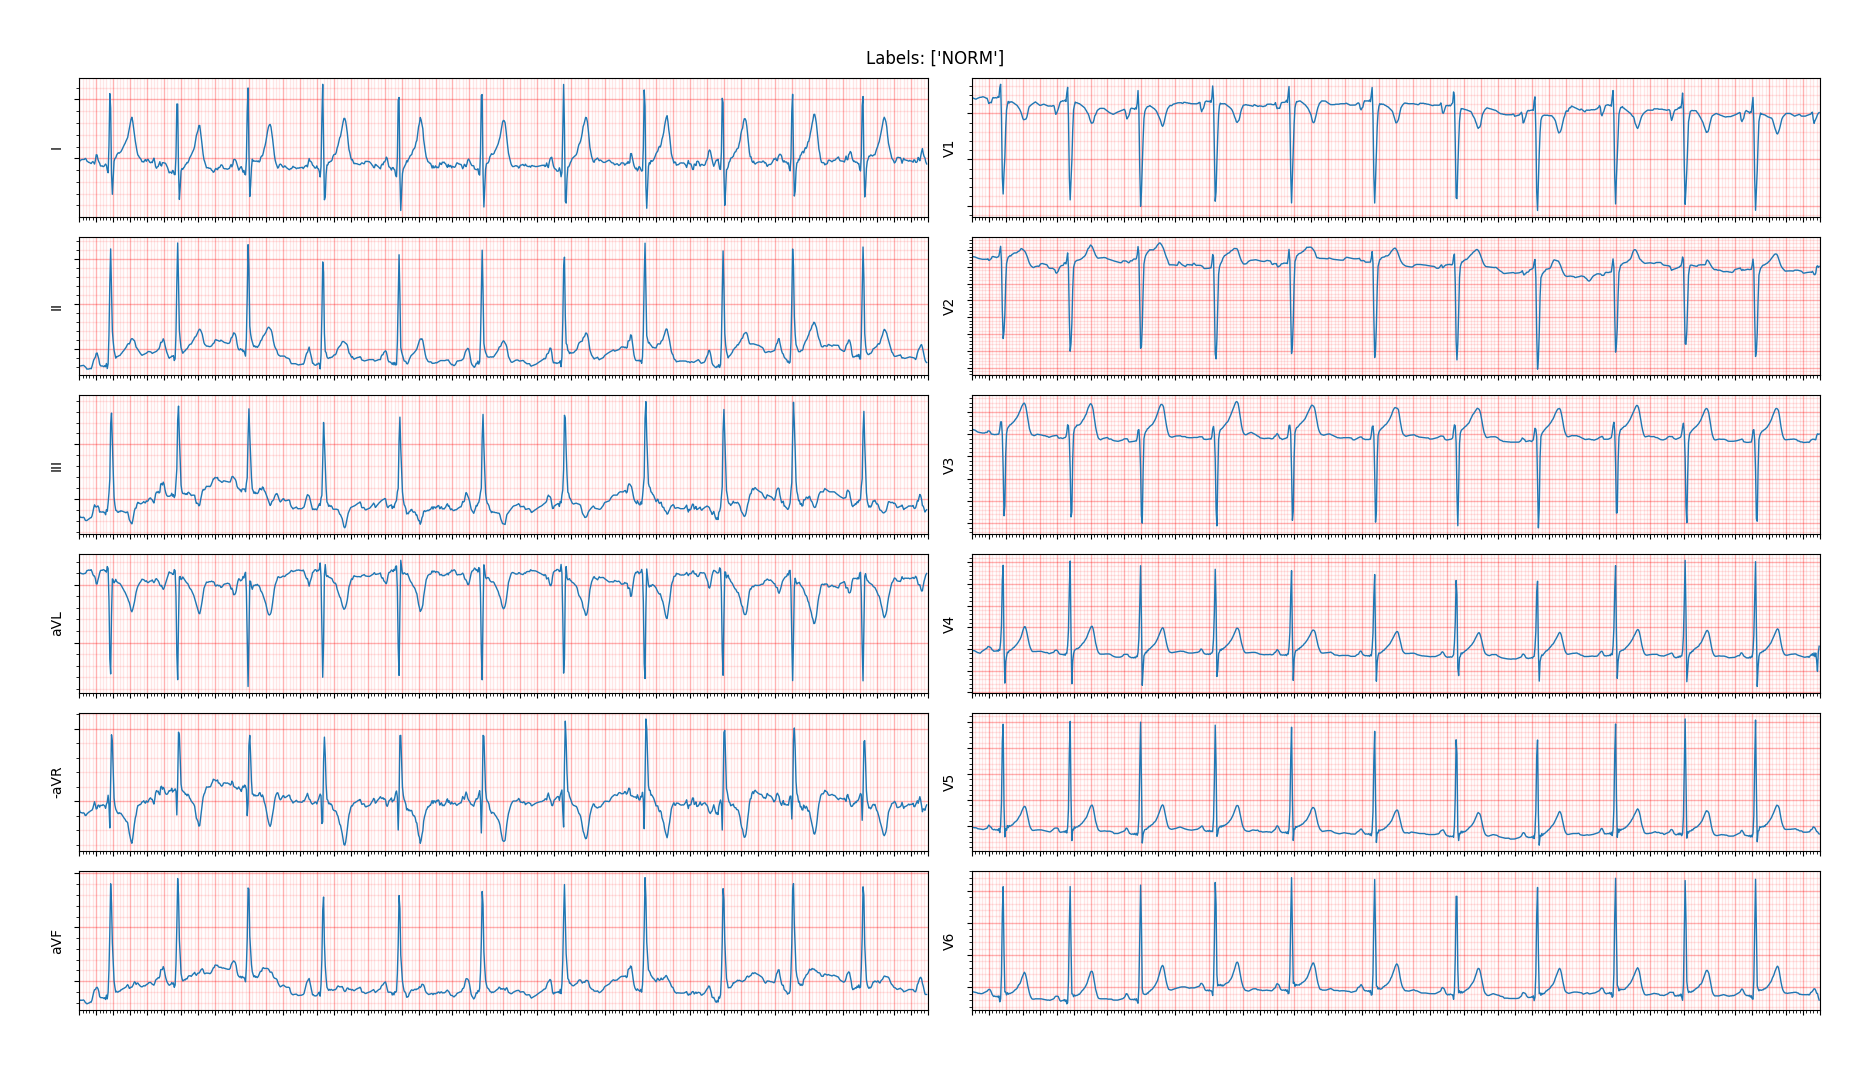

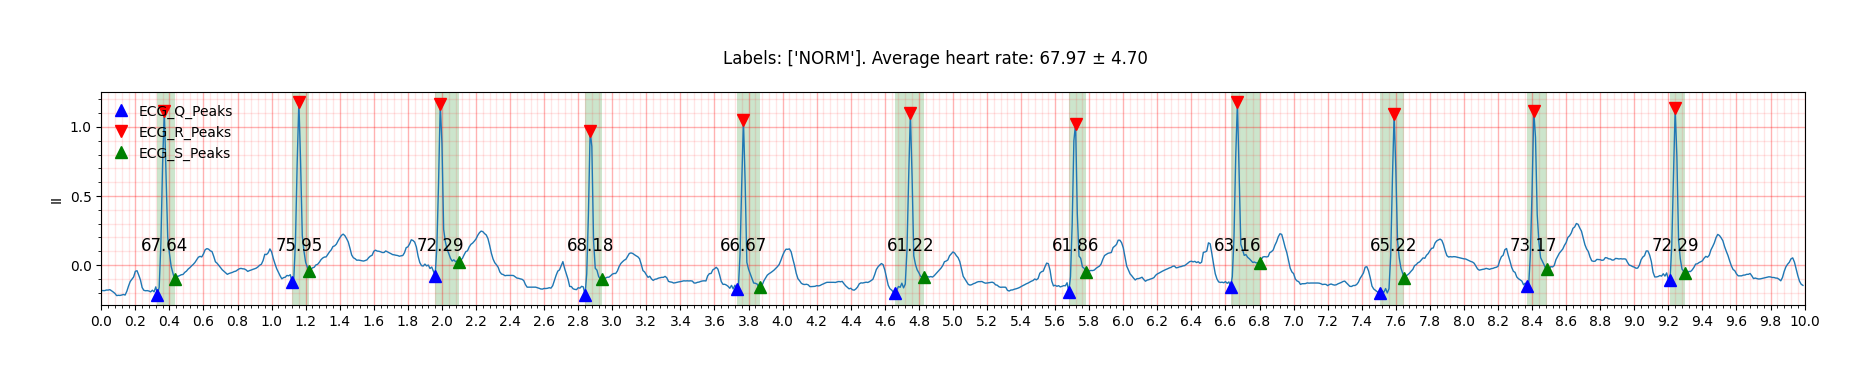

In [21]:
plot_by_index(np.where(y_train["NORM"])[0][50])

The following patient with myocardial infarction and conduction disturbance shows a noisier signal, but peaks are correctly detected nonetheless.

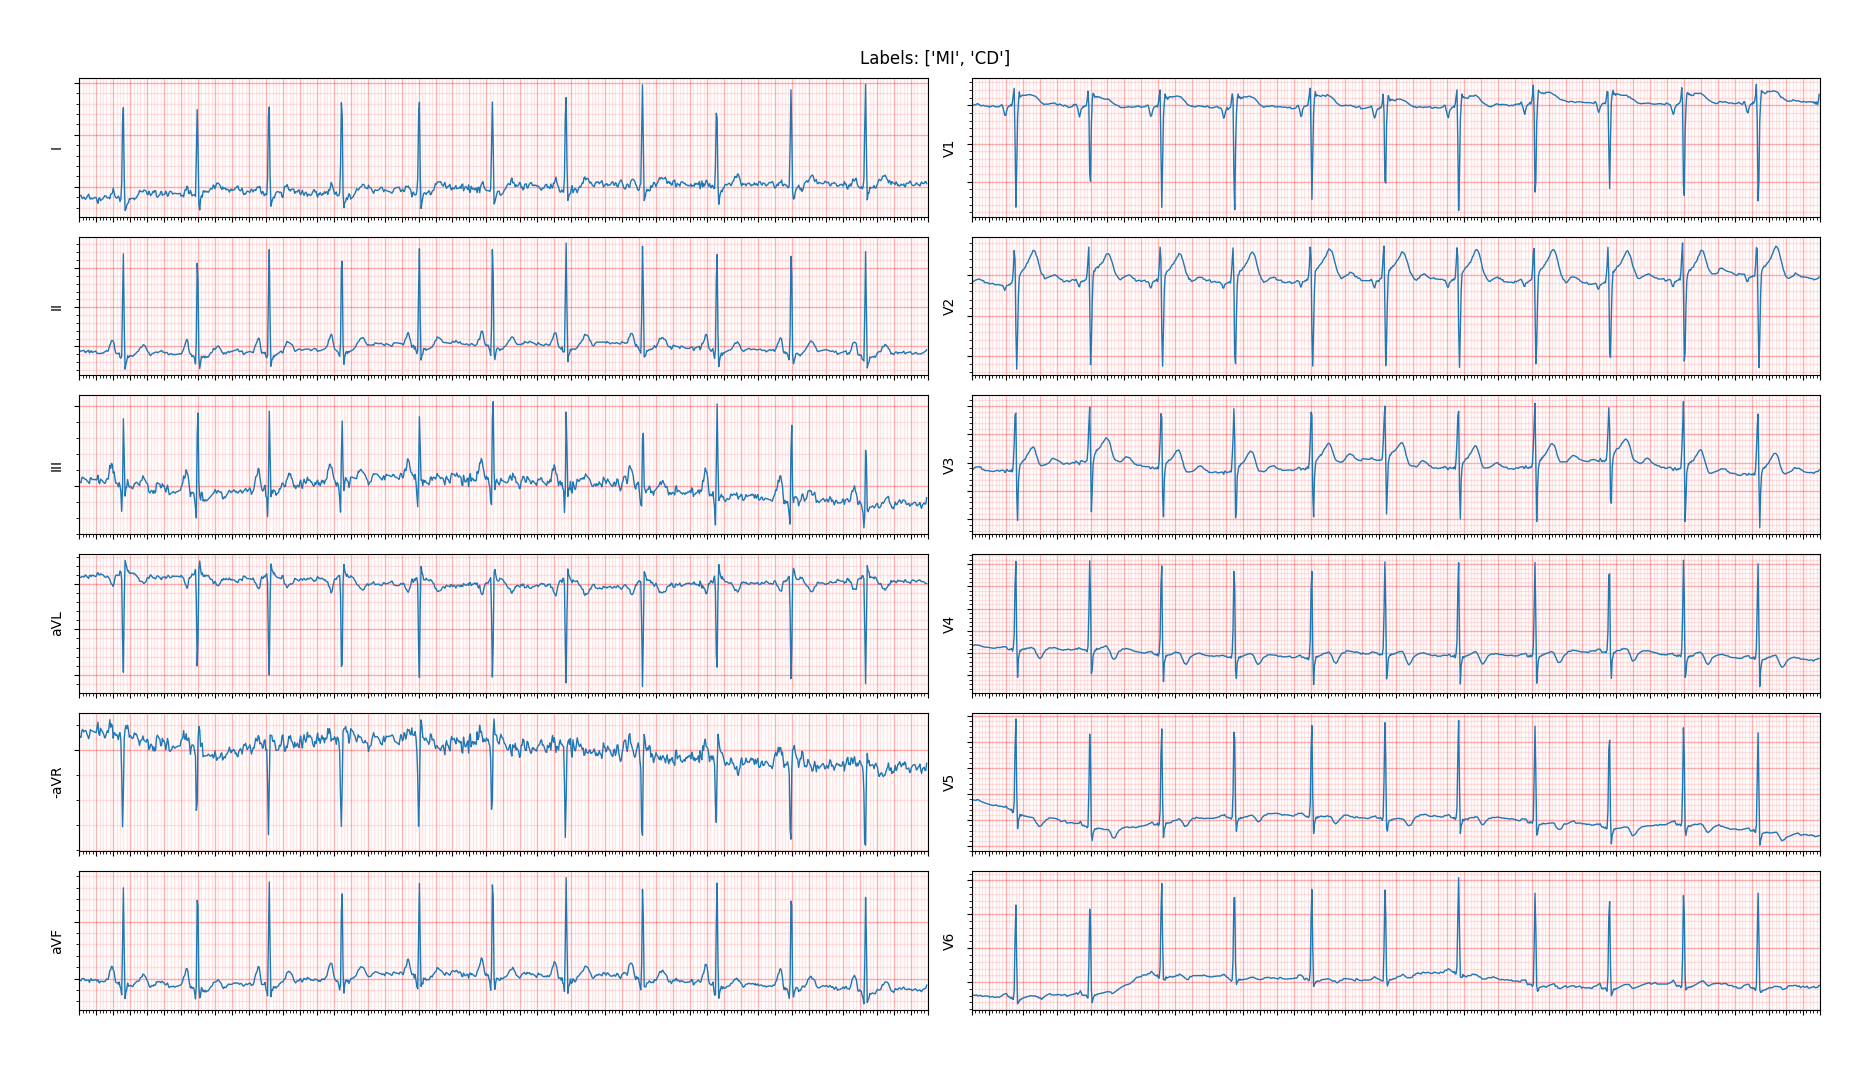

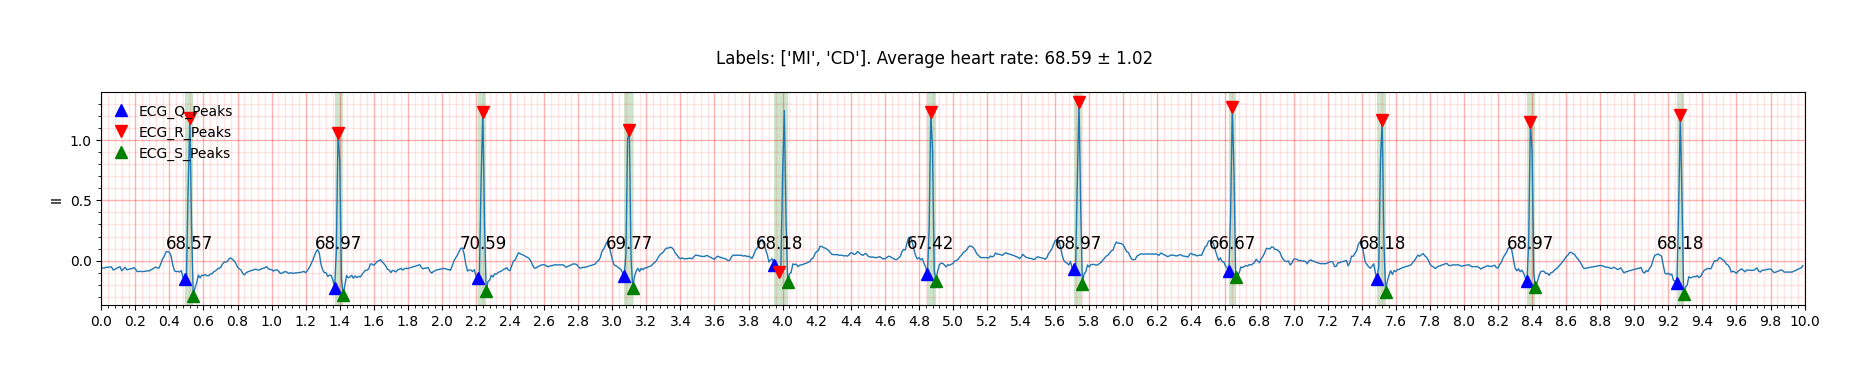

In [22]:
plot_by_index(np.where(y_train["CD"])[0][50])

The following patient is annotated as presenting hypertrophy and ST/T waves change.

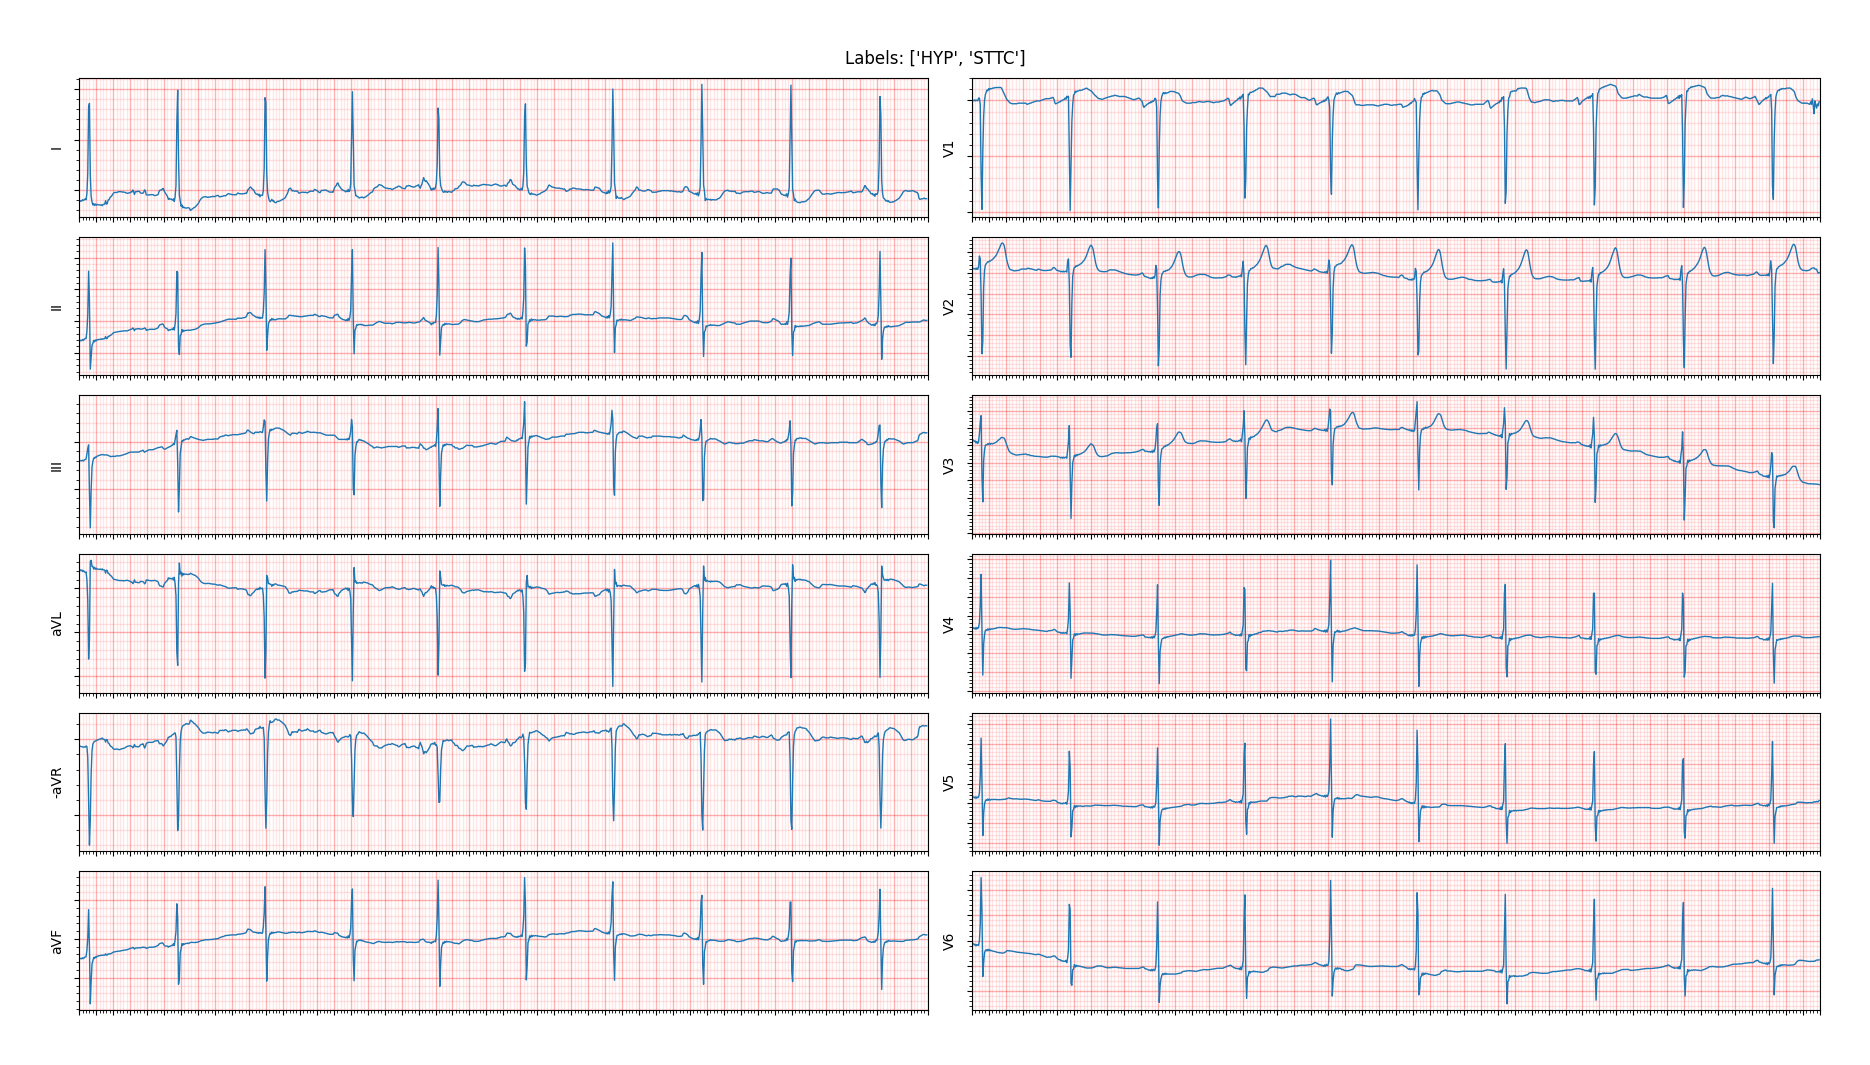

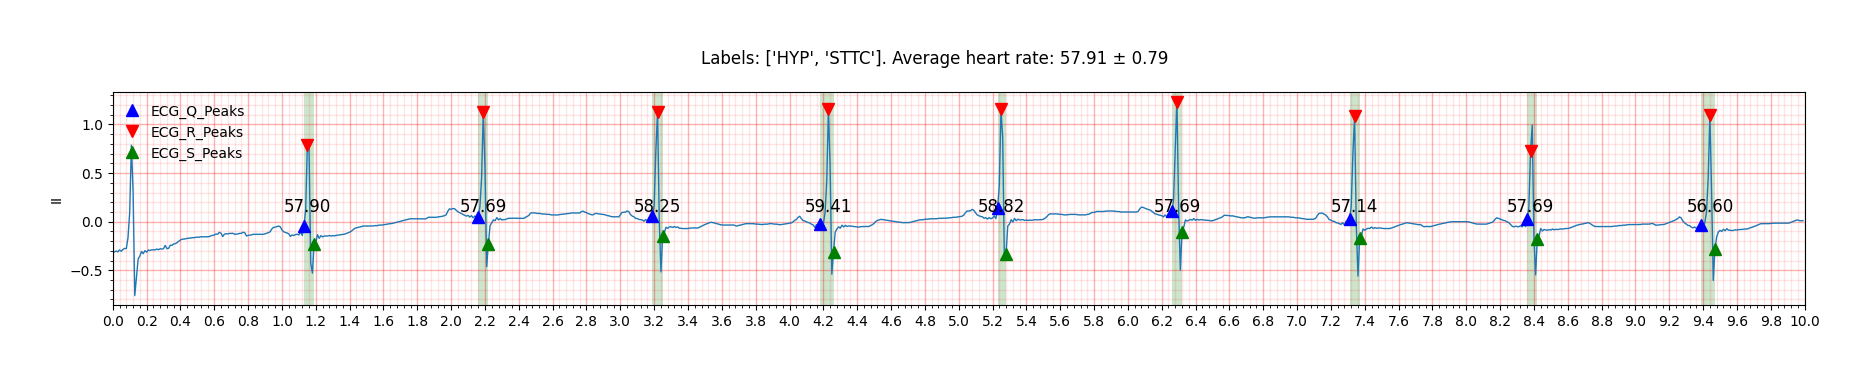

In [23]:
plot_by_index(np.where(y_train["STTC"])[0][50])

#### Anomalous rhythm detection

In order to provide automatic detection of anomalous rhythms in these ECGs, a simple method would be to inspect the coefficient of variation (CV) of the heart rates measured by NeuroKit2. The CV is a statistical measure of variance that is independent of the mean, and is thus **comparable between different samples**. Here we extract the CV for the heart rates of the first 1000 samples in the training set, and we can see that most of them fall within the $[0, 12]$ interval but there are many outliers. Some of these outliers may be due to detection errors in NeuroKit2 (possibly detecting extra beats that are not actually present). Others, however, may be indicating potential arrhythmias.

<Axes: >

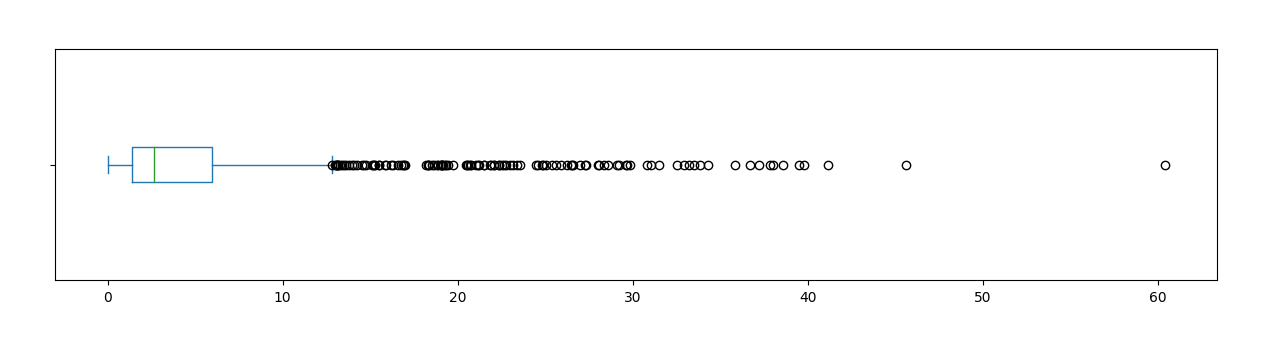

In [24]:
def heartrate_cv(signal, show=False):
    try:
        df, _ = nk.ecg_process(signal, sampling_rate=sampling_rate)
        rate = nk.ecg_rate(df, sampling_rate=sampling_rate)
        if show:
            print(rate)
            print(np.nanstd(rate))
            print(np.nanmean(rate))
            print(100 * np.nanstd(rate)/np.nanmean(rate))
        return 100 * np.nanstd(rate)/np.nanmean(rate)
    except IndexError:
        return 0
    except ValueError:
        return 0

heartrate_cv(X_train[180][:, 0])
heartrate_variance = pd.Series([heartrate_cv(X_train[i][:, 1]) for i in range(1000)])
heartrate_variance.plot(kind="box", figsize=(15,3), vert=False)

Now, finding potential arrhythmic samples can be as easy as filtering the CVs in a reasonable range outside what can be considered normal. We can also filter by label in order to obtain only individuals annotated as not presenting any other anomaly:

In [25]:
heartrate_variance.iloc[np.where(
    (15 < heartrate_variance) * 
    (heartrate_variance < 20) * 
    np.array(y_train["NORM"].iloc[:1000])
)]

192    15.521570
221    16.295234
479    15.893876
636    18.317771
767    16.174003
dtype: float64

For example, the 221st instance, whose heart rate computes to a CV of 16, clearly presents changes in heart rate along the ECG:

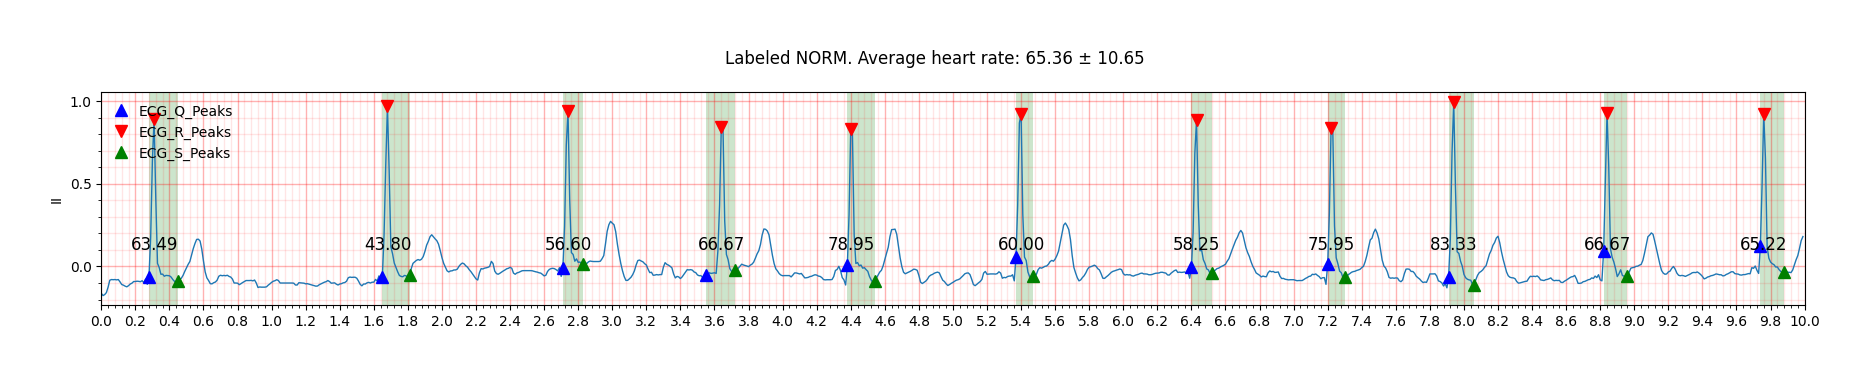

In [26]:
plot_with_peaks(X_train[221], title=f"Labeled {','.join(y_train.columns[y_train.iloc[221]])}")
plt.show()

## 4. Data modeling

Detecting QRS complexes and assisting to the diagnosis of potential arrythmias is not the only task we could achieve using this dataset. Since it provides a large number of samples with their annotated labels indicating diagnosis, we can train a machine learning model which will be capable of describing unseen ECG signals with the appropriate labels. If this model can confidently detect potential pathologies using a 12-lead ECG, it could **accelerate the diagnosis of cardiovascular issues** and alleviate a time-consuming task for cardiologists, especially in stressful settings such as ER rooms.

### 4.1. Model definition and training

Due to the size of the dataset, a deep learning model would be adequate. These models hold a large number of parameters that can be better optimized when a large dataset is available. Furthermore, informing the model about the sequential nature of the data can help reduce the number of trainable parameters. This is why we will use a one-dimensional convolutional network instead of the more structure-agnostic fully connected network. In order to avoid  the infamous vanishing gradient problem, skip connections will be added to the network (making it a residual network or ResNet).

In [27]:
import tensorflow as tf
if USE_GPU:
    physical_devices = tf.config.list_physical_devices('GPU') 
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

def residual_block(filters):
    def func(x):
        block = x
        filter_length = [8, 5, 3]
        for i, length in enumerate(filter_length):
            block = tf.keras.layers.Conv1D(filters, length, 1, padding="same")(x)
            block = tf.keras.layers.BatchNormalization()(block)
            if i < len(filter_length) - 1:
                block = tf.keras.layers.ReLU()(block)
        
        if x.shape[-1] == filters:
            shortcut = x
        else:
            shortcut = tf.keras.layers.Conv1D(filters, 1, 1, padding="same")(x)

        block = tf.keras.layers.Add()([block, shortcut])
        block = tf.keras.layers.ReLU()(block)
        return block
    return func

def resnet_1d(filters, num_classes, activation):
    def func(x):
        net = residual_block(filters)(x)
        net = residual_block(filters * 2)(net)
        net = residual_block(filters * 2)(net)
        net = tf.keras.layers.GlobalAveragePooling1D()(net)
        net = tf.keras.layers.Dense(num_classes, activation=activation)(net)
        return net
    return func

2023-03-06 17:10:09.991902: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-06 17:10:10.057896: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-06 17:10:10.379792: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-06 17:10:10.379824: W tensorflow/compiler/xl

Once the model is defined, we can build it according to the shape of the input data (5000 points $\times$ 12 leads). Notice that the output of the network will be given by a dense (fully connected) layer with as many units as superclasses and **a sigmoid activation, which will provide an output in the $[0,1]$ interval** for each label. This is because multiple labels can be assigned to the same input, so it does not make sense to apply the more usual softmax activation. 

In [28]:
in_ly = tf.keras.layers.Input(shape=X_train.shape[1:])
out_ly = resnet_1d(64, len(SUPERCLASSES), "sigmoid")(in_ly)
model = tf.keras.models.Model(in_ly, out_ly)

2023-03-06 17:10:10.707222: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


The residual network architecture will have the following structure: three residual blocks [Convolution -> Batch normalization -> ReLU -> Add(skip connection)], a global average pooling step which eliminates the samples dimension, and the output dense layer.

In [29]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1000, 12)]   0           []                               
                                                                                                  
 conv1d_2 (Conv1D)              (None, 1000, 64)     2368        ['input_1[0][0]']                
                                                                                                  
 batch_normalization_2 (BatchNo  (None, 1000, 64)    256         ['conv1d_2[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 conv1d_3 (Conv1D)              (None, 1000, 64)     832         ['input_1[0][0]']            

Next step is training the model. Skip the following cell if training is not convenient, since the process will be slow. A pre-trained model is provided in the file `best_checkpoint.h5` and is loaded below.

In [ ]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=[tf.keras.metrics.BinaryAccuracy()])
hist = model.fit(X_train, y_train, batch_size=64, epochs=50, validation_data=(X_val, y_val), callbacks=[
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint(filepath="model.{epoch:02d}-{val_loss:.2f}.h5")
])
model.save("best_checkpoint.h5")

The saved model with the best weights according to validation loss is retrieved here:

In [30]:
model = tf.keras.models.load_model("best_checkpoint.h5")
model.evaluate(X_val, y_val)

69/69 [==============================] - 1s 14ms/step - loss: 0.3024 - binary_accuracy: 0.8732


[0.30239641666412354, 0.8732020258903503]

### 4.2. Model evaluation

By default, Tensorflow/Keras include some evaluation metrics that are useful with binary or multiclass problems. In our case, only `BinaryAccuracy` is appropriate since it matches predictions and ground truth as arrays of binary labels ([source](https://github.com/keras-team/keras/blob/e6784e4302c7b8cd116b74a784f4b78d60e83c26/keras/utils/metrics_utils.py#L918)). However, this is not the only adequate metric to evaluate the performance on a multilabel task. 

It is important to notice that, although in binary or multiclass classification each prediction can only be right or wrong, in a multilabel scenario a classifier would be able to partially predict the correct labelset (e.g., predicting only the `HYP` label for a patient that has both `HYP` and `STTC`). This is why evaluating multilabel classifiers can require a little more nuance, as well as paying attention to which metrics are more affected by imbalance.

In order to assess classifier performance for this problem, we will analyze the following metrics:
- Binary accuracy (not strict "accuracy"): will report the ratio of overall correct individual predictions, considering that an instance can have a partially correct prediction.
- Zero-one loss: the ratio of incorrectly predicted labelsets (lower is better). Less permissive than binary accuracy and hamming loss, this metric will only consider a prediction as either fully correct or wrong, even if just one label is incorrectly predicted.
- Hamming loss: the hamming distance between the ground truth and the predictions (lower is better). Should be $1-\text{binary_accuracy}$.
- Precision for `NORM`: the ratio of instances predicted as `NORM` that are actually normal. This would give an idea of the amount of ECGs with pathologies that could be ignored by using this method (if precision is low, the system would give more false negatives).
- Recall for `NORM`: the ratio of normal instances correctly predicted as such (if recall is low, many patients with normal ECGs would be detected as abnormal)

In [31]:
from sklearn import metrics
def macro_f1(y_true, y_pred): return metrics.f1_score(y_true, y_pred, average="macro")
def micro_f1(y_true, y_pred): return metrics.f1_score(y_true, y_pred, average="micro")
zero_one_loss = metrics.zero_one_loss
hamming_loss = metrics.hamming_loss
def normal_precision(y_true, y_pred): return metrics.precision_score(y_true, y_pred, labels=[0], average="macro")
def normal_recall(y_true, y_pred): return metrics.recall_score(y_true, y_pred, labels=[0], average="macro")

my_metrics = {
    "binary_accuracy": tf.keras.metrics.BinaryAccuracy(),
    "zero_one_loss": zero_one_loss,
    "hamming_loss": hamming_loss,
    "macro_f1": macro_f1,
    "micro_f1": micro_f1,
    "normal_precision": normal_precision,
    "normal_recall": normal_recall
}

After obtaining model predictions for the test subset, we can compute the previously defined metrics:

In [32]:
predictions = model.predict(X_test)
predicted_labels = predictions > CLASSIFICATION_THRESHOLD
performance = {n: np.float(f(y_test, predicted_labels)) for n, f in my_metrics.items()}
display(pd.DataFrame(performance, index=["value"]))

69/69 [==============================] - 1s 14ms/step


,binary_accuracy,zero_one_loss,hamming_loss,macro_f1,micro_f1,normal_precision,normal_recall
value,0.872065,0.415833,0.127934,0.698165,0.737589,0.79222,0.867082


Some observations are to be made following these metrics:

- Although binary accuracy and hamming loss indicate relatively good performance from our deep learning model, we have to take into account that they only measure the ratio of overall right/wrong answers, not considering full labelsets and not distinguishing by label.
- Zero-one loss indicates that the classifier is able to assign the exact correct labelset to around 58% of instances. This is a good start minding that there are 5 different labels and 4 of them are notably coupled between them, but a closer inspection would be needed to check whether the majority of those correct labelsets actually correspond to instances with just the `NORM` label.
- Macro-averaged F1 score is not affected by label imbalance (since it's first computed by label and then averaged), and since its result is slightly lower than micro-averaged F1, we can deduce that some of the minority labels are seeing worse performance than majority ones. In our case, probably the `NORM` class is being modeled better than the rest, especially `HYP` which is the least frequent label.
- The precision and recall scores for the `NORM` label are more or less confirming the previous suspicions that the model is able to distinguish this class better than the rest. However, the main objective for this kind of model would be to primarily distinguish between normal and abnormal ECGs, so the fact that 4 out of 5 "normal" predictions are right is promising. Furthermore, almost 87% of normal individuals are correctly identified, meaning that the amount of false positives will be relatively low.

We can further inspect the label-by-label results by printing the confusion matrices for each label:

In [33]:
for cm, kl in zip(metrics.multilabel_confusion_matrix(y_test, predicted_labels), SUPERCLASSES):
    display(pd.DataFrame(cm, columns=[f"{kl} not predicted", f"{kl} predicted"], index=[f"Not {kl}", f"True {kl}"]))

,NORM not predicted,NORM predicted
Not NORM,1016,219
True NORM,128,835


,HYP not predicted,HYP predicted
Not HYP,1886,50
True HYP,138,124


,MI not predicted,MI predicted
Not MI,1558,89
True MI,221,330


,STTC not predicted,STTC predicted
Not STTC,1494,183
True STTC,117,404


,CD not predicted,CD predicted
Not CD,1654,47
True CD,214,283


As shown by the evaluation metrics, the model performs notably better for the `NORM` label than for the rest. This is probably due to **normal ECGs being easier to distinguish from anomalous ones than ECGs presenting different pathologies** between them. The number of false negatives for labels other than `NORM` and `STTC` is still unacceptable, and would require further analysis. A possible source for many false negatives could be that the classifier is unsure for every label and is not predicting any label for some instances. Let's perform a quick check to see if this assumption would hold:

In [34]:
not_predicted = np.sum(np.all(~predicted_labels, axis=1))
unlabeled = (-y_test).all(axis=1).sum()
print(f"There are {unlabeled} unlabeled instances in the test set but {not_predicted} were predicted with no labels by the classifier.")

There are 39 unlabeled instances in the test set but 173 were predicted with no labels by the classifier.


### 4.3. Prediction explanations

In a medical context, it is typically not enough to present a result predicted by a machine learning model if a practitioner cannot understand why the prediction was made in the first place. Since deep learning models are essentially black boxes, they are not easy no interpret by themselves so an additional method for obtaining explanations would be convenient.

In the following, we will use LIME, a very popular model explanation technique, that uses local linear approximations in order to identify **which aspects of the input are actually influencing the classification output** of the model. In particular, the version available in library `lime_timeseries` adapts LIME for sequential numerical data.

In [35]:
from lime_timeseries import LimeTimeSeriesExplainer

With the aim of providing an interesting example, we will look for a test instance which presents abnormalities in its ECG. For example, the classifier predicts classes `HYP`, `MI` and `STTC` for test instance number 39:

In [36]:
display(pd.DataFrame(model.predict([X_test[30:40]]), columns=SUPERCLASSES))

1/1 [==============================] - 0s 62ms/step


,NORM,HYP,MI,STTC,CD
0,0.932092,0.011418,0.018176,0.005418,0.180848
1,0.993125,0.000973,0.002665,0.001470,0.015185
2,0.528547,0.006733,0.348238,0.012304,0.108944
3,0.968180,0.008660,0.004031,0.010205,0.019142
4,0.359472,0.136174,0.220628,0.084592,0.249157
5,0.995065,0.001185,0.001542,0.002166,0.010926
6,0.983023,0.006077,0.019227,0.006469,0.008431
7,0.359190,0.010404,0.190625,0.733115,0.015614
8,0.863398,0.079101,0.007671,0.141610,0.060361
9,0.002562,0.658979,0.944118,0.825556,0.142756


We can check that this prediction is correct by obtaining the same row in the ground truth:

In [37]:
y_test.iloc[39]

NORM    False
HYP      True
MI       True
STTC     True
CD      False
Name: 271, dtype: bool

The original ECG data in each instance is composed of 12 channels (leads) and 1000 or 5000 points depending on the sampling rate selected. Since obtaining an "importance" score for each one of thousands of variables for a given instance would be costly, we will group several points together in a slice. This way, we will keep the number of channels but reduce the points to a more manageable number.

The following function makes use of the explainer object and LIME methods in order to extract a weight or "importance" for each slice in each signal. Then a ranking plot is generated for the explained class and the 12-lead plot is shown with certain sections highlighted. **Green sections contribute to the positive prediction** of the explained class, while **red sections contribute to a negative prediction**.

In [38]:
signals = ["I", "II", "III", "aVL", "aVR", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"]
variable_to_index = dict(zip(signals, range(len(signals))))

def explain_test_instance(explained_instance, explained_class, num_slices=20):
    num_features = X_test[explained_instance].shape[1]
    num_samples = X_test[explained_instance].shape[0]
    
    explainer = LimeTimeSeriesExplainer(class_names=SUPERCLASSES, signal_names = signals)
    # This library expects instances in shape (channels, samples) but our data is in format (samples, channels)
    # so we need to transpose axes both in the instance and in the prediction function
    explanation = explainer.explain_instance(
        np.transpose(X_test[explained_instance]), 
        lambda x: model.predict(np.swapaxes(x, 1, 2)),
        labels=range(len(SUPERCLASSES)),
        num_features=num_features, 
        num_samples=num_samples, 
        num_slices=num_slices)
    
    # Shows a ranking of the most important "slices"
    explanation.as_pyplot_figure(label=explained_class)
    plt.show()
    
    # Each weight is associated to a string with the format "slice - signal", which we
    # have to split in order to retrieve the variable and the slice
    expl_list = explanation.as_list(label=explained_class)
    weights = [[] for _ in range(len(signals))]
    for location, weight in expl_list:
        slice_number, variable_name = location.split(" - ")
        ivar = variable_to_index[variable_name]
        islice = int(slice_number)
        weights[ivar].append((islice, weight))
    
    # Generate the 12-lead plot...
    values_per_slice = np.ceil(num_samples / num_slices)
    fig, ax = plot_12lead(X_test[explained_instance], title=f"Explained instance for label {SUPERCLASSES[explained_class]}")

    # ...and annotate the important slices by highlighting the background
    for i in range(num_features):
        ax[i%6, i//6].grid(which='minor', color='r', linestyle='-', linewidth=0, alpha=0)
        for loc, weight in weights[i]:
            start = loc * values_per_slice
            end = start + values_per_slice
            color = 'red' if weight < 0 else 'green' 
            ax[i%6, i//6].axvspan(start, end, color=color, alpha=np.clip(abs(weight*10), 0, 1))

    plt.show()

Next, we will obtain explanation plots for the selected instance and the `HYP` label (use 2 for `MI` and 3 for `STTC`):

32/32 [==============================] - 0s 13ms/step


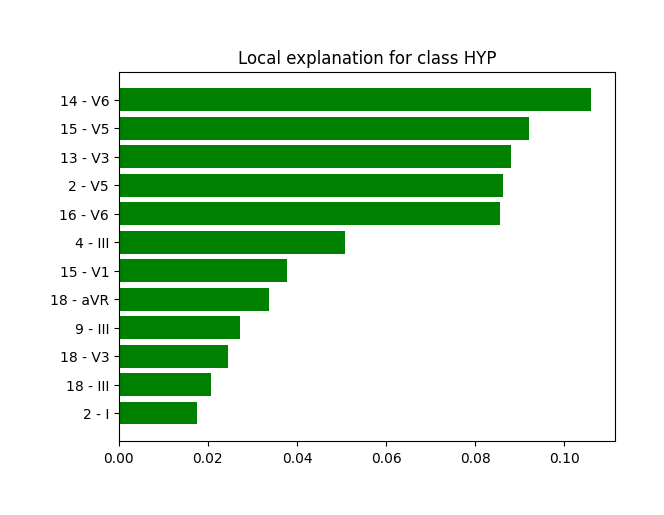

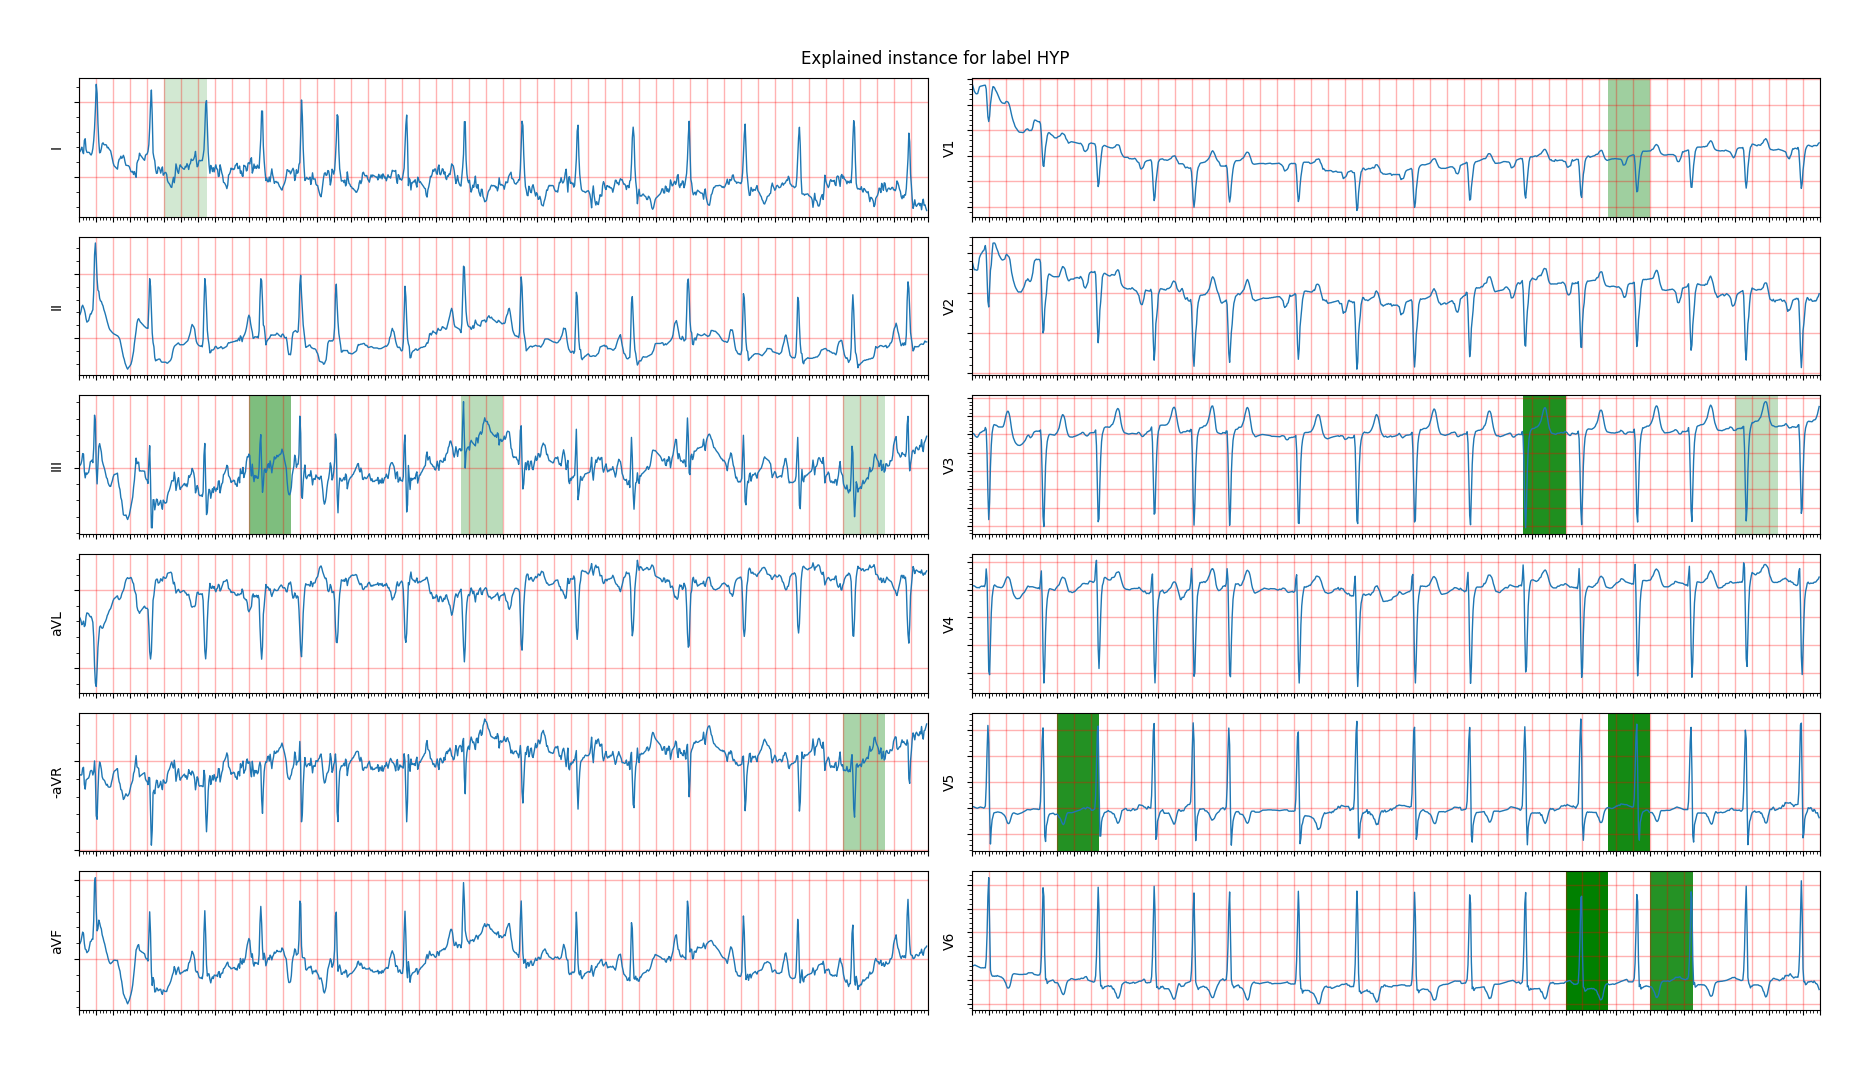

In [40]:
explain_test_instance(39, 1)

According to [some sources](https://ecgwaves.com/topic/ecg-left-ventricular-hypertrophy-lvh-clinical-characteristics/) a criteria for detecting hypertrophy relies on V5 and V6 leads, and in the explanation above we can see the most highlighted sections mainly in those leads. Of course, these explanations should be contrasted with professionals in order to check whether the deep learning model is focusing on the right spots when predicting each label.

## 5. Conclusions

This section summarizes the knowledge and interesting aspects obtained during the above document. 

### What does this study achieve?

This study has completed several tasks regarding the analysis of ECG data from the PTB-XL dataset. Firstly, the problem has been identified as a **multilabel classification problem** according to the "superclass" categorization of possible diagnoses. This has led to the study of relations among labels and label imbalance. Additionally, the ECG data has been plotted in two ways that can help a practitioner: a standard 12-lead plot and a detailed Lead II plot with QRS complexes and heart rate information. A simple method to extract individuals with potential arrhythmias has been devised as well.

With regards to data modeling, a baseline model has been developed using a deep convolutional neural network with skip connections, also known as a ResNet. This model has performed fairly well when distinguishing normal from abnormal instances in the test set but falls a bit short on performance for the rest of labels. However, it is a strong starting point to iterate upon. A model explanation method, LIME, has been used in order to calibrate the importance of each section in each lead for any given prediction. Even if the predictions are not as accurate as desired, the **explanations could help draw practitioners' attention to the most relevant sections** of the ECG signals.

### What does the data reveal?

There exist dozens of cardiovascular disorders that can be identified by means of an electrocardiogram signal, but we have focused on detecting general categories (superclasses) since this can allow to quickly discriminate between people that present a disorder and those who do not. This has **left out a small number of individuals with specific situations** such the presence of a pacemaker or rarer disorders, which a professional should diagnose with more detail.

The study of label coocurrence and imbalance has revealed that **one label (`HYP`) is especially prone to appearing coupled** with others instead of on its own, and is notably less frequent than the rest. This label should be harder to predict by a classifier, a fact that was later confirmed when evaluating the deep learning model. However, this also means that when a patient is diagnosed with hypertrophy, their data should be paid attention in order to detect additional diagnoses.

The process of plotting ECG data in 12-lead and detailed form revealed that some other aspects of each instance may not be covered by the labels. For example, a simple method to detect anomalous heart rhythms was able to find possible **arrhythmias in instances classified as normal**. Arrhythmias are fairly common and not necessarily a sign of disease, but this method could help quickly detect patients that, even with no detected pathologies, may need additional attention by a medical professional.

The baseline deep learning model is able to predict individual labels correctly around 87% of the time and the exact labelset (all labels for a given instance) in almost 60% of cases. Not all labels, however, are equally well detected. These results provide the intuition that this dataset can be fairly well modeled by machine learning and that, with further developments on the network and possible data cleaning and resampling, the performance could improve.

### What are possible next steps?

The following are possible directions where this study could be continued:

- The additional variables provided in the `Y` data frame could be useful to clean noisy instances, but there are many missing values so a careful analysis would be necessary.

- Instances could be resampled in an attempt to balance the presence of labels. This would be hindered by the fact that the minority label `HYP` is coupled closely with other labels, but there exist specific resampling mechanisms for multilabel data that could help with this problem.

- In order to obtain quick improvements on the developed model, a hierarchical version could employ two neural networks, the first discriminating between `NORM` instances and the rest, and the second one processing only instances detected as abnormal to predict which pathology is present. This hierarchical model could then be extended to detect subclasses of the five main superclasses.

- Additional models could be compared to the baseline as well, for example including a recurrent neural network model. LSTMs and GRUs are especially designed for sequential data and would be appropriate competitors to the CNN.


### Other observations

A possible bug in NeuroKit2 was identified when processing several ECGs. More specifically, instance number 334 in `X_train` causes the `ecg_process()` function to fail. The source seems to be that it detects/looks for an event in index 1000 but this is out of range for 100Hz instances. This detail was ignored previously in the interest of time but further revision and submitting a patch upstream could be appropriate.